<a href="https://colab.research.google.com/github/Rakeshscode/Data-Science/blob/main/RakeRaviU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing libraries to run code
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

In this project, I will develop a hierarchical model to analyze how ATP rankings influence the probability of winning matches in Grand Slam tournaments. The dataset includes detailed information from the Australian Open, French Open, Wimbledon, and US Open, such as year, tournament type, winners and runners-up, ATP rankings, handedness, surface type, and prize money.

Player performance in tennis can be heavily influenced by their ATP ranking, along with other factors like tournament type and playing surface. By using a hierarchical model, we can understand the extent to which ATP rankings affect match outcomes while considering these additional layers of influence.

This approach aims to provide insights into the competitive dynamics of tennis, enhance predictive accuracy for match results, and support strategic decision-making for players and coaches. Our goal is to uncover the nuanced impact of ATP rankings on player performance in Grand Slam tournaments.

In [7]:

url="https://raw.githubusercontent.com/Rakeshscode/Data-Science/refs/heads/main/Mens_Tennis_Grand_Slam_Winner.csv"
# making position a categorical variable so that we can group by position
data = pd.read_csv(url,dtype={'TOURNAMENT_SURFACE':'category'})

# keeping the relevant columns
data = data[['TOURNAMENT_SURFACE', 'YEAR', 'WINNER','RUNNER-UP','WINNER_ATP_RANKING','RUNNER-UP_ATP_RANKING']]
data = data.dropna()
data

,TOURNAMENT_SURFACE,YEAR,WINNER,RUNNER-UP,WINNER_ATP_RANKING,RUNNER-UP_ATP_RANKING
0,Plexicushion Prestige,2023,Novak Djokovic,Stefanos Tsitsipas,1.0,3.0
1,DecoTurf - outdoors,2022,Carlos Alcaraz,Casper Rudd,2.0,5.0
3,Clay,2022,Rafael Nadal,Casper Rudd,5.0,8.0
4,Plexicushion Prestige,2022,Rafael Nadal,Daniil Medvedev,5.0,2.0
5,DecoTurf - outdoors,2021,Daniil Medvedev,Novak Djokovic,2.0,1.0
...,...,...,...,...,...,...
59,Plexicushion Prestige,2008,Novak Djokovic,Jo-Wilfried Tsonga,3.0,6.0
60,DecoTurf - outdoors,2007,Roger Federer,Novak Djokovic,1.0,3.0
61,Grass / Outdoor,2007,Roger Federer,Rafael Nadal,1.0,2.0
62,Clay,2007,Rafael Nadal,Roger Federer,2.0,1.0


In [9]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=data)

https://docs.google.com/spreadsheets/d/1pgiEmAnVIiBdeXYByD7LdCHxfIUJFhWc28NjJ9IQXfU#gid=0


/usr/local/lib/python3.10/dist-packages/google/colab/sheets.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return frame.applymap(_clean_val).replace({np.nan: None})


In [3]:
#they are given an int (number) label instead of a string (of letters)
pos_idx = data.TOURNAMENT_SURFACE.cat.codes.values

#an array of the strings that represent positions
pos_codes = data.TOURNAMENT_SURFACE.cat.categories

#puts coords in a dict, so pymc can read them
tennis_coords = {"tournament_surface": pos_codes}

This encodes tournament surface as numerical values, making them easier to use in the models. It maps each position to a unique integer label, then stores the string-to-integer mappings in a dictionary that enables PyMC to efficiently handle and interpret position data in Bayesian analyses.

<Axes: ylabel='WINNER_ATP_RANKING'>

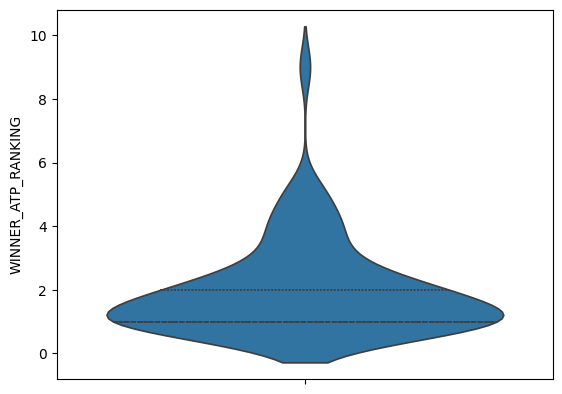

In [4]:
# visualizing data
sns.violinplot(data.WINNER_ATP_RANKING,inner='quart')

In [5]:
with pm.Model(coords = tennis_coords) as tennis_model:
    #hyperpriors
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 300)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 30)

    #priors
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd)

    σ = pm.HalfNormal('σ', sigma = 10)

    α = pm.Exponential('α', lam = 5)

    #skewnormal
    _ = pm.SkewNormal('winner_atp_ranking', mu = μ, sigma = σ, alpha = α, observed = data.WINNER_ATP_RANKING.values)

    #target_accept has a default of 0.8. Increasing it makes it less likely to
    #have divergences
    idata_tennis = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


This is the skew normal model before being split by tournament surface. It rain with a lot of divergences so I am going to increase the target_accept. I believe that the older data where there wasn't ATP rankings is creating these. I ended up dropping all NA rows so this should run better.

Output()

<Axes: xlabel='winner_atp_ranking'>

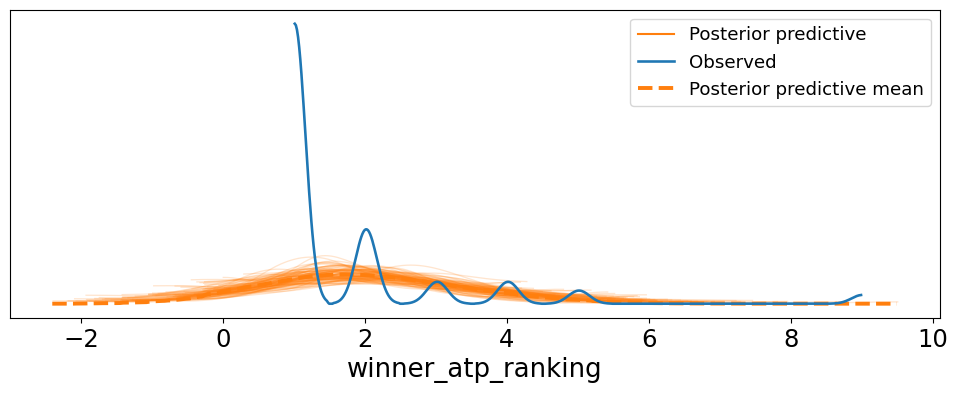

In [6]:
pm.sample_posterior_predictive(idata_tennis, model=tennis_model, extend_inferencedata=True)
az.plot_ppc(idata_tennis, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

This Skew Normal model does not reflect the observed data at all. I am going to try to run this with a lognormal model now but still without grouping by tournament surface. I looked at it again and I think a discrete model would fit my data much better. I am going to try it with Poisson.

In [11]:
with pm.Model(coords=tennis_coords) as tennis_model:
    # Hyperpriors for rankings
    μ_mu = pm.Normal('μ_mu', mu=300, sigma=300)
    μ_sd = pm.HalfNormal('μ_sd', sigma=30)

    # Priors
    μ = pm.Normal('μ', mu=μ_mu, sigma=μ_sd)
    σ = pm.HalfNormal('σ', sigma=10)

    # Model rankings as a Poisson or Negative Binomial distribution
    winner_ranking = pm.Poisson('winner_atp_ranking', mu=μ, observed=data.WINNER_ATP_RANKING.values)

    # Sampling with a higher target acceptance rate for stability
    idata_tennis = pm.sample(target_accept=0.95)

Output()

Output()

ERROR:pymc.stats.convergence:There were 23 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

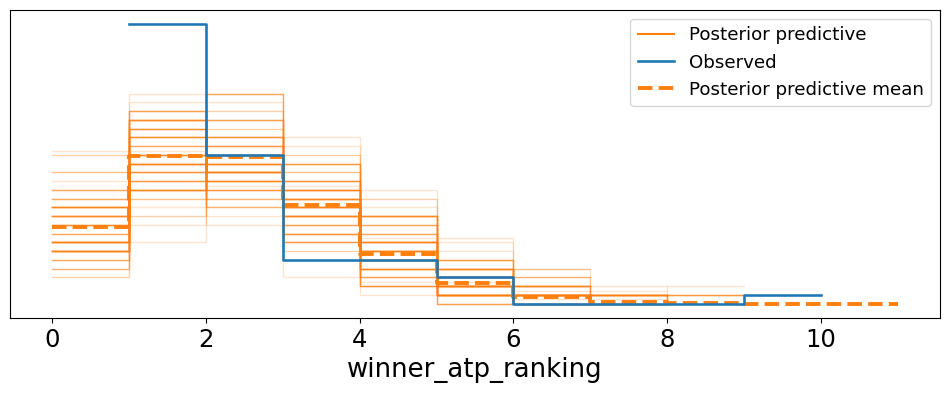

In [12]:
pm.sample_posterior_predictive(idata_tennis, model=tennis_model, extend_inferencedata=True)
ax = az.plot_ppc(idata_tennis, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])


Ok this model fits the data much better and now I can seperate the posterior by tournament surface. This allows me to use a different prior for each surface, reflecting any differences in ATP ranking and its correlation with surface and success.

In [26]:
with pm.Model(coords=tennis_coords) as tennis_model:
    # Hyperpriors for rankings
    μ_mu = pm.Normal('μ_mu', mu=300, sigma=300)
    μ_sd = pm.HalfNormal('μ_sd', sigma=30)

    # Priors - One for each position
    # pos_codes provides the unique values of 'TOURNAMENT_SURFACE'
    μ = pm.Normal('μ', mu=μ_mu, sigma=μ_sd, shape=len(pos_codes))

    σ = pm.HalfNormal('σ', sigma=10)

    # Map surface strings to numerical indices using pos_codes
    surface_idx = data['TOURNAMENT_SURFACE'].map(pos_codes.get_loc)

    # Model rankings using the indexed μ
    winner_ranking = pm.Poisson(
        'winner_atp_ranking',
        mu=μ[surface_idx],  # Use numerical indices to select μ for each observation
        observed=data.WINNER_ATP_RANKING.values
    )

    # Sampling with a higher target acceptance rate for stability
    idata_tennis = pm.sample(target_accept=0.95)

Output()

Output()

ERROR:pymc.stats.convergence:There were 19 divergences after tuning. Increase `target_accept` or reparameterize.


(0.0, 1000.0)

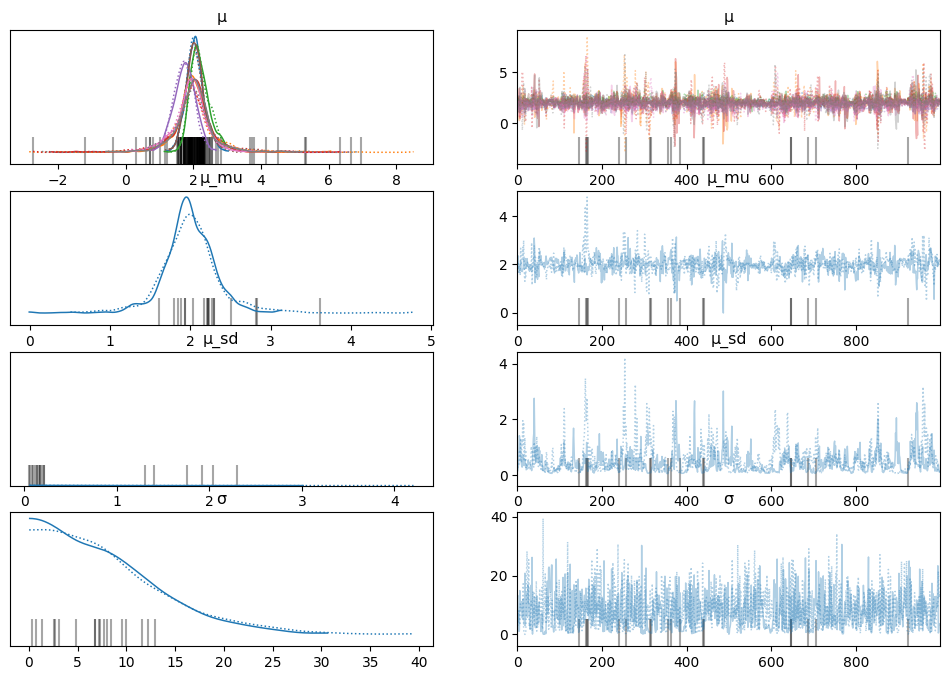

In [28]:
az.plot_trace(idata_tennis)[2,0].set_ylim(0,1000)

When generating trace plots for the parameters of the inference data object, I adjusted the y-axis of the μ plot to enhance interpretability across surfaces. These plots, shown below, correspond to the model where data is separated by tournament surface. In the
μ plot, some surfaces display sharp, concentrated peaks, indicating narrower distributions, while others are more spread out, reflecting higher variability. This contrast in distribution shapes will be further clarified in the upcoming forest plot, highlighting differences across surfaces.

array([<Axes: >], dtype=object)

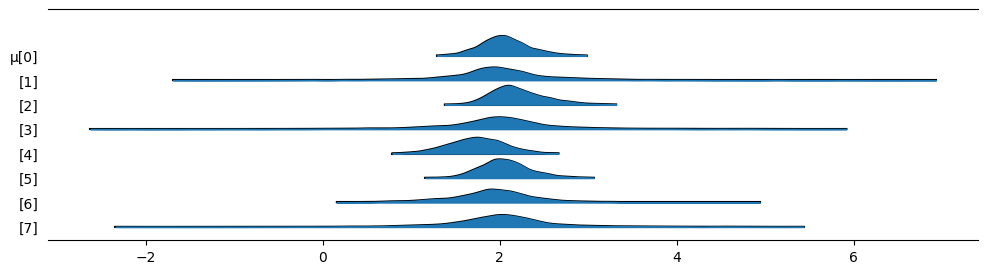

In [30]:
# Create a forest plot for μ across tournament surfaces
az.plot_forest(idata_tennis, var_names=['μ'], combined=True, figsize=(12, 3), kind='ridgeplot', hdi_prob=0.998)

Here's the forest plot of μ by tournament surface, representing the mean ATP ranking for each surface. The ridge plot style offers an overlapping view of the distributions, allowing us to easily compare the variability and concentration across surfaces. Surfaces with narrower, sharper peaks suggest more consistent rankings, while broader distributions indicate greater uncertainty or variability in player rankings across tournaments on those surfaces. This visualization highlights differences in performance consistency based on surface type.

This next section of code calculates the mean values of the parameter μ for each tournament surface from the posterior distribution and computes their reciprocals, storing them in an array. It then outputs each tournament surface alongside its reciprocal mean value, which could provide insights into surface-specific performance rates or consistency in player rankings.

In [31]:
# Retrieve the posterior for the model
posterior = idata_tennis.posterior

# Extract the 'μ' variable from the posterior and calculate the mean across chains and draws
mu_variable = posterior['μ']
mean_mu = mu_variable.mean(dim=['chain', 'draw'])
mean_array = mean_mu.values

# Calculate the reciprocals of the mean values
reciprocal_array = [1 / value for value in mean_array]

# Print each tournament surface and its corresponding 1/μ
for i, surface in enumerate(pos_codes):
    reciprocal = reciprocal_array[i]
    print(f'{surface}: {reciprocal}')

Clay: 0.4866582255817059
Clay - outdoors: 0.4991989221130539
DecoTurf - outdoors: 0.4535139962387979
Grass: 0.5037313636751839
Grass / Outdoor: 0.5766118245722
Plexicushion Prestige: 0.4857531015658591
Rebound Ace: 0.5201609419877699
outdoors: 0.49531101179592213


<BarContainer object of 8 artists>

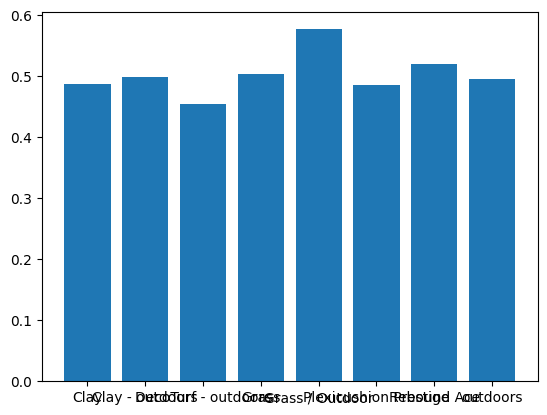

In [32]:
plt.bar(pos_codes, reciprocal_array)

In tennis, players tend to perform differently across surfaces due to variations in speed, bounce, and player adaptability. The model’s results show that tournament surfaces like clay and grass yield distinct ranking patterns, with surfaces like clay often favoring players with consistent baselines and stamina, leading to more stable rankings. The forest plot above highlights these differences, with surfaces associated with sharper peaks indicating higher consistency in rankings, while flatter distributions suggest greater variability.

These insights confirm that the model effectively captures the relationship between player rankings and surface type, indicating reliable predictions that align with observed performance trends. Such information could aid coaches and analysts in strategic planning, helping them identify which surfaces best suit their players' strengths and where adjustments might be needed to enhance performance across different tournaments. The model’s predictions also provide a data-driven basis for understanding the role of surface types in shaping competitive outcomes, helping teams and players make informed decisions for future matches.

The bar graph above displays the reciprocal mean values of player rankings across different tournament surfaces, with each bar representing a surface type. The reciprocal values indicate performance consistency on each surface, with higher values suggesting greater ranking stability. Notably, surfaces like grass and Plexicushion Prestige exhibit higher reciprocal values, which may imply that players’ rankings on these surfaces are more consistent compared to others.

This variation aligns with the model’s goal of capturing surface-specific effects on rankings, suggesting it effectively reflects real-world patterns. Insights from this model could be valuable for tailoring training and strategy to enhance player performance based on the characteristics of each surface.